# Chapter 10 Predicting Continuous Target Variables with Regression Analysis

 Exploring and visualising datasets
 Training regression models that are robust to outliers
 Evaluating regression models and diagnosing common problems
 Fitting regression models to nonlinear data

## Exploring the Housing dataset

 Loading the Housing dataset into a dataframe

Attributes:

<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
             25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
             river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
             by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
</pre>

In [1]:
import pandas as pd


df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Visualizing the important characteristics of a dataset

First, we will create a scatterplot matrix that allows us to visualize the pair-wise correlations between the different features in this dataset

Using `pairplot` function from the `Seaborn` library (for drawing statistical plots based on `Matplotlib`)

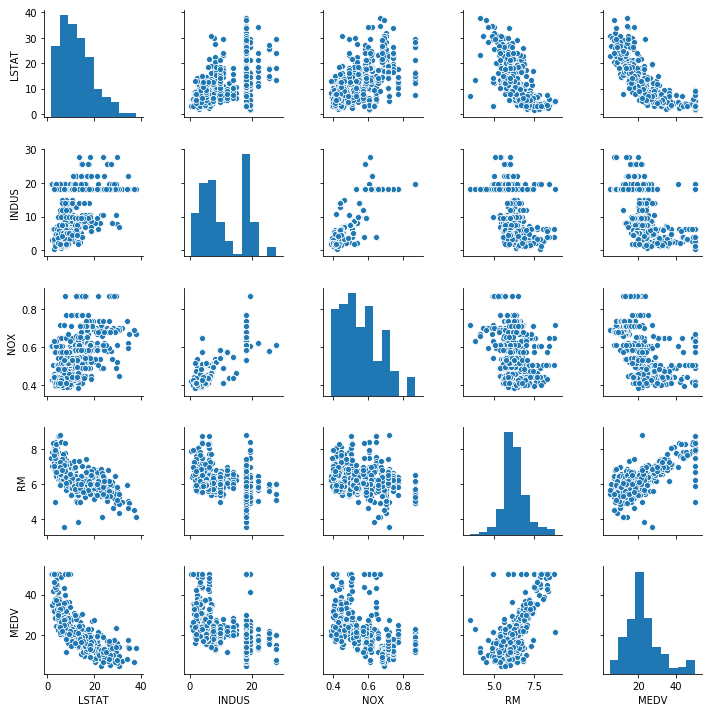

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['LSTAT','INDUS','NOX','RM','MEDV']

sns.pairplot(df[cols],height = 2)
plt.tight_layout()
plt.show()

## Looking at relationships using a correlation matrix

#### Correlation matrix: 
- Quantify and summarize linear relationships between variables
- a square matrix that contains correlation coefficient
    - measure the linear dependence between pairs of features

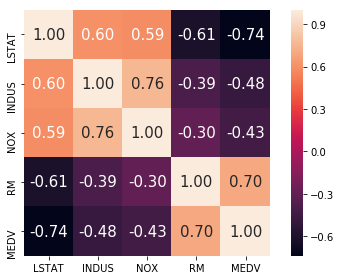

In [9]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar = True,
                 annot = True,
                 square = True,
                 fmt = '.2f',
                 annot_kws = {'size': 15},
                 yticklabels = cols,
                 xticklabels = cols)
plt.tight_layout()
plt.show()




## Implementing an ordinary least squares linear regression model

### Solving regression for regression parameters with gradient descent

In [10]:
class LinearRegressionGD(object):
    
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        self.w_ = np.zeros(1+X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self,X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    
    def predict(self,X):
        return self.net_input(X)
    

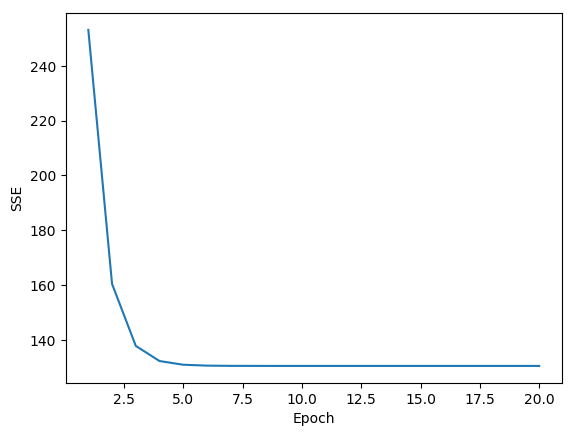

In [12]:
# try

X = df[['RM']].values
y = df['MEDV'].values

# Standardize the variables for better convergence of the GD algorithm

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)

# workaround regarding y_std
# most scikit-learn expect data to be stored in two-dimensional arrays
# `np.newaxis` add a new dimension to the array
# after the StandardScaler returned the scaled variable
# convert it back to the original one-dimensional array representation
# using `flatter()`
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_std, y_std)

# plot the cost as a function of the numbers of epochs passes over the training dataset
# using optimization algorithms, such as gradient descent to check the algorithm converged to a cost minimum

sns.reset_orig() #resets matplotlib style
plt.plot(range(1,lr.n_iter+1),lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

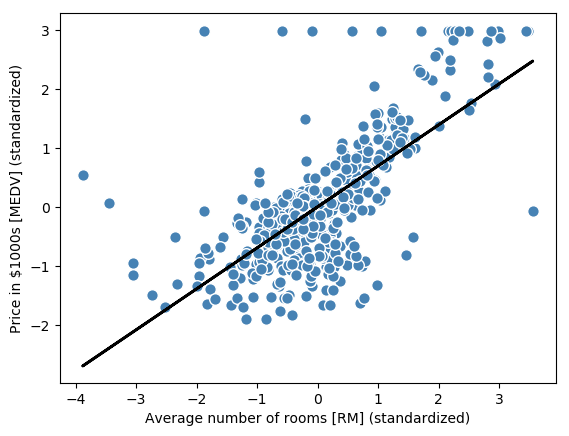

In [13]:
# Visualize how well the linear regression line fits the training data

# define a simple helper function
#  - plot a scatterplot of the training samples and add the regression line

def lin_regplot(X,y,model):
    plt.scatter(X,y,c='steelblue',edgecolors='white',s=70)
    plt.plot(X,model.predict(X), color = 'black', lw = 2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [15]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [17]:
#report the predicted outcome variables on their original scale

num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


## Estimating the coefficient of a regression model via scikit-learn

In [19]:
from sklearn.linear_model import LinearRegression

slr=LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)


Slope: 9.102
Intercept: -34.671


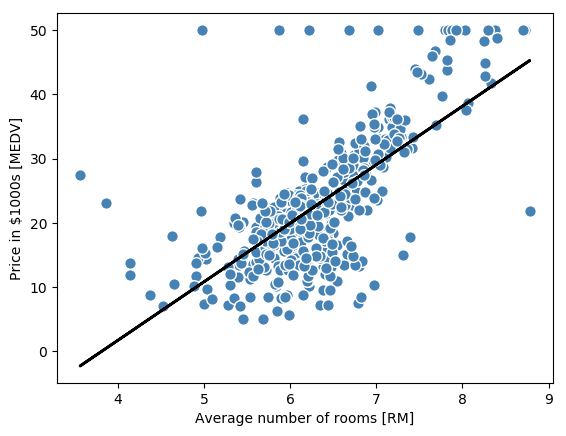

In [20]:
lin_regplot(X,y,slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## Fitting a robust regression model using RANSAC

Motivation: Outliers problem

Solution 1: throw out outliers

Solution 2: RANSAC

RANSAC: Random Sample Consensus (RANSAC) algorithm

- fit a regression model to a subset of the data
- inliers

Summarize the iterative RANSAC algorithms as follows:
1. Select a random number of samples to be inliers and fit the model
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers
3. Refit the model using all inliers
4. Estimate the error of the fitted model v.s. the inliers
5. Termniate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations were reached; go back to step 1 otherwise.


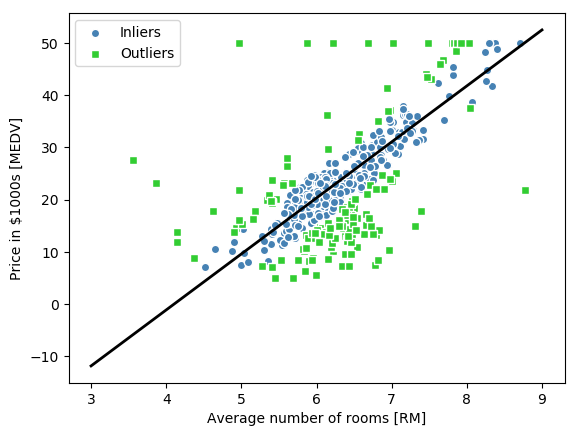

In [23]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials = 100,
                         min_samples = 50,
                         loss = 'absolute_loss', # argument for the `residual_metric` parameter
                         # the algorithm computes absolute vertical distances between the fitted line and the sample points
                         residual_threshold = 5.0, # allow the vertical distance to be less than 5 distance unit
                         random_state = 0)
# By default, scikit-learn uses the MAD (Median Absolute Deviation of the target values y)
# estimate to select the inlier threshold
# inlier threshold is problem-specific, one disadvantage of RANSAC

ransac.fit(X,y)

# after fit the RANSAC model, obtain the inliners and outliners from the fitted RANSAC-linear regression model
# and plot them together with the linear fit:

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])

plt.scatter(X[inlier_mask], y[inlier_mask],
            c = 'steelblue', edgecolor = 'white',
            marker = 'o', label = 'Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c = 'limegreen', edgecolor = 'white',
            marker = 's', label = 'Outliers')

plt.plot(line_X, line_y_ransac, color = 'black', lw = 2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc = 'upper left')
plt.show()



In [25]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models

In [27]:
# use all variables in the dataset and train a multiple regression model

from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


In [28]:
import numpy as np
import scipy as sp

ary = np.array(range(100000))

In [29]:
%timeit np.linalg.norm(ary)

49.5 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%timeit sp.linalg.norm(ary)

49.6 µs ± 157 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
%timeit sp.sqrt(np.sum(ary**2))

83.5 µs ± 314 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Since our model uses multiple explanatory variables, we cannot visualize the linear regression line (or hyperplane to be precise) in a 
two dimensional plot.

But we can plot the residuals v.s. the predicted values to diagnose our regression mode

### Residual Plot

- help detect nonlinearity and outliers, and 
- check whether the errors are randomly distributed

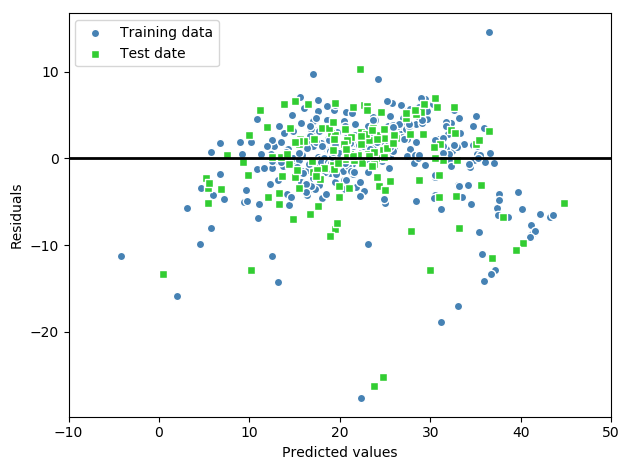

In [32]:
plt.scatter(y_train_pred, y_train_pred - y_train,
            c = 'steelblue', marker = 'o', edgecolor = 'white',
            label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c = 'limegreen', marker = 's', edgecolor = 'white',
            label = 'Test date')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, color = 'black', lw = 2)
plt.xlim([-10,50])
plt.tight_layout()

plt.show()

A good regression model: the errors should be randomly distributed

If we see patterns in a residual plot, it means that our model is unable to capture some explanatory information, which has leaked into the residuals.

Outliers: points with a large deviation from the centerline

### MSE and $R^2$


In [34]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# MSE: average value of the SEE cost contributed by each sample
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train,y_train_pred),
        mean_squared_error(y_test,y_test_pred)))

# R^2: the fraction of response variance that is captured by the model
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


## Using regularized methods for regression

- tackle the problem of overfitting by adding additional information
- shrinking the paramter values of the model to induce a penalty against complexity
- e.g. Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), Elastic Net

### Ridge Regression
- L2 penalized model
- Add the squared sum of the weights to our least-squares cost function
- Increase the value of hyperparameter $\lambda$, increase the regularization strength, and shrink the weights of our model
- Noted that we don't regularize the intercept temr $w_0$

### LASSO
- L1 penalized model
- Sparse model
- depending on the regularization strength, certain weights can become zero

### Elastic Net
- Ridge Regression + LASSO
- L1 penalty to generate sparsity
- L2 penalty to overcome some of the limitations of LASSO

#### Regularized strength: $\lambda$
- optimise via e.g. k-fold cross-validation

In [35]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

## Turning a linear regression model into a curve - polynomial regression

- Account for the violation of linearity assumption (linear relationship between explanatory and response variables)

- Use a polynomial regression model by adding polynomial terms

- $d$ denotes the degree of the polynomial

### Adding polynomial terms using scikit-learn

- use `PolynomialFeatures` transformer class from `scikit-learn`
- add a quadratic term (d = 2) to a simple regression problem with one explanatory varaible
- compare the polynomial to the linear fit


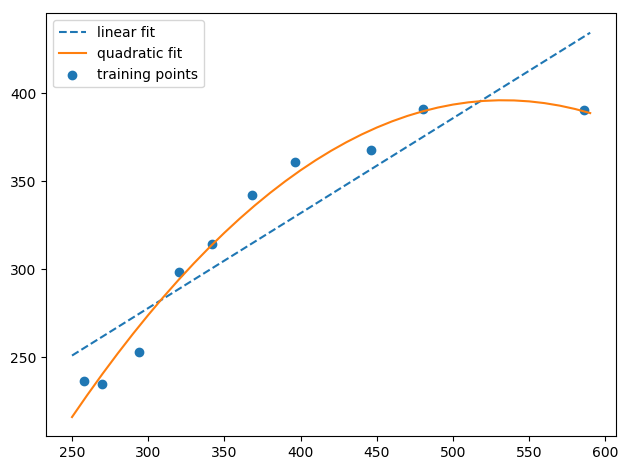

In [36]:
# 1. Add a second degree polynomial term

X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()

quadratic = PolynomialFeatures(degree = 2)
X_quad = quadratic.fit_transform(X)

# 2. Fit a simple linear regression model for comparison

# fit linear features
lr.fit(X,y)
X_fit = np.arange(250,600,10)[:,np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 3. Fit a multiple regression model on the transformed features for polynomial regression
# fit quadratic features
pr.fit(X_quad,y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# 4. Plot the results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label = 'linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'quadratic fit')

plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Polynomial fit captures the relationship between the response and explanatory variable much better than the linear fit

In [39]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y,y_lin_pred), 
        mean_squared_error(y,y_quad_pred)))

print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))


Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset

Model the relationship between house prices and LSTAT (percent lower status of the population) as the using second degree (quadratic) and third degree (cubic) polynomials and compare it to a linear fit

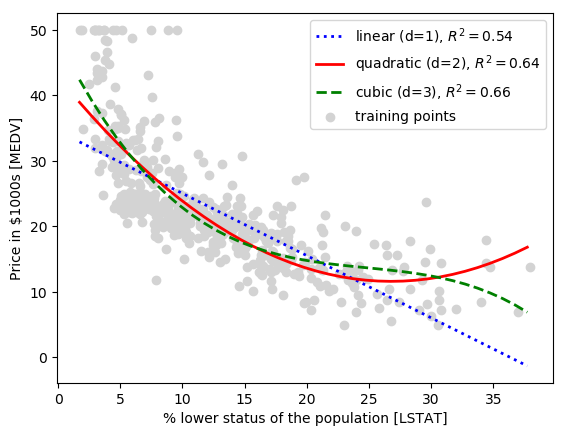

<Figure size 640x480 with 0 Axes>

In [44]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(),X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label = 'training points', color = 'lightgray')

plt.plot(X_fit, y_lin_fit, 
         label = 'linear (d=1), $R^2=%.2f$' % linear_r2,
         color = 'blue', lw = 2, linestyle = ':')

plt.plot(X_fit, y_quad_fit,
         label = 'quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color = 'red', lw = 2, linestyle = '-')

plt.plot(X_fit, y_cubic_fit,
         label = 'cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color = 'green', lw = 2, linestyle = '--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc = 'upper right')

plt.show()

plt.tight_layout()
plt.show()

Cubic works best, but be aware of the danger of overfitting

Polynomial features are not always the best choice for modeling nonlinear relationships
e.g. What about a log-transformation(exponential) and square root?

#### Transforming the dataset

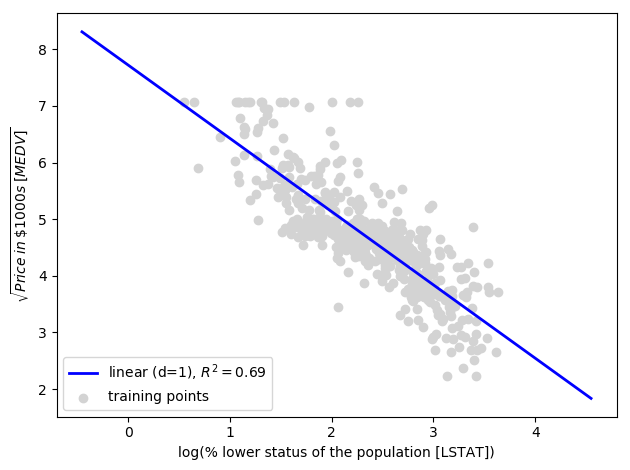

In [45]:
# transform features

X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1,
                  X_log.max()+1,1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('images/10_12.png', dpi=300)
plt.show()

## Dealing with nonlinear relationships using random forests

### Random forest Regression
- ensemble of multiple decision tree
- sum of piecewise linear functions
- subdividing the input space into smaller regions that become more manageable

### Decision tree regression
- not required any transformation of the features if we are dealing with nonlinear data
- grow a decision tree by iteratively splitting its nodes until the leaves are pure or a stopping criterion is satisfied
- find the feature split that **Maximize the Information Gain**
- find the feature split that reduces the impurities in the child nodes most
- Gini impurity and entropy -> classification/discrete variables
- Continuous variables: MSE of a node => **Within-node variance**
    - Splitting criterion is also known as **Variance Reduction**
    
Use `DecisionTreeRegressor` implemented in scikit-learn to model the nonlinear relationship between the MEDV and LSTAT variables

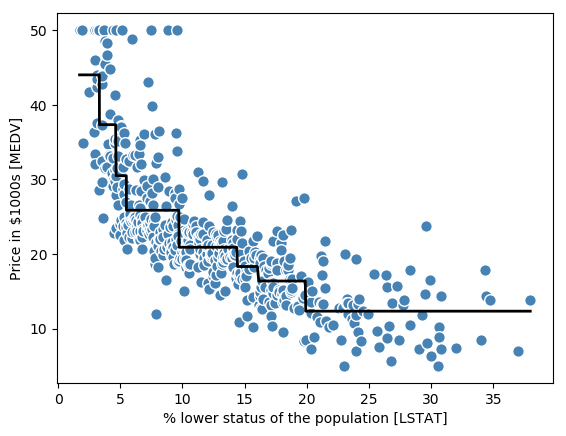

In [46]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth = 3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

The decision tree captures the general trend in the data
But a limitation of this model is that it does not capture the continuity and differentiability of the desired prediction

## Random forest regression

- Combines multiple decision tree
- better generalization performance due to randomness
- decrease the model's variance
- less sensitive to outliers
- not require parameter tunning
- Only parameter need to experiment: number of trees in the random forest algorithm
- Continuous data: 
    - use MSE criterion to grow the individual decision trees
    - the predicted target variable is calculated as the average prediction over all decision trees
    
Use all features in the Housing dataset to fit a random forest regression model on 60% of the samples and evaluate its performance on the remaining 40%

In [51]:
X = df.iloc[:,:-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size  = 0.4, random_state = 1)

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators = 1000,
                               criterion = 'mse',
                               random_state = 1,
                               n_jobs = -1)

forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


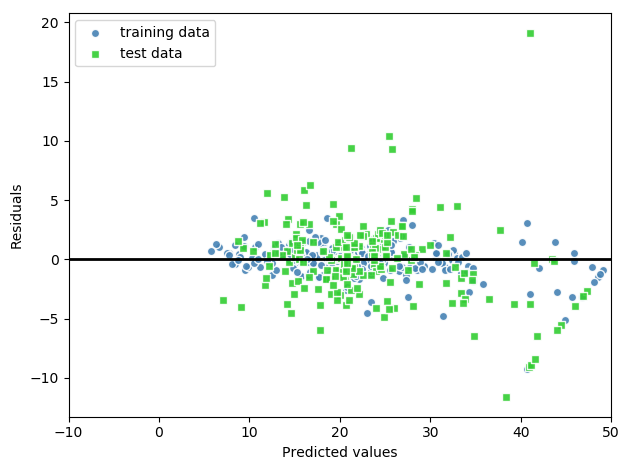

In [52]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()